## Q0 - RECS and Replicate Weights

There are three primary files being used for this exercise,
they are linked below:
1. [Microdata - 2009](https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public.csv)
2. [Replicate Weights - 2009](https://www.eia.gov/consumption/residential/data/2009/csv/recs2009_public_repweights.csv)
3. [Microdata and Replicate Weights - 2015](https://www.eia.gov/consumption/residential/data/2015/csv/recs2015_public_v4.csv)

While this dataset has a large number of variables
(described in the [codebook](https://www.eia.gov/consumption/residential/data/2009/xls/recs2009_public_codebook.xlsx), this exercise uses only a small subset to address a very specfic question.

These variables are:
- DOEID: A unique ID representing a household whose power
consumption has been recorded
- REGIONC: One of four Census Regions (Midwest, Northeast, South, West)
- HDD65: The Heating Degree Days recorded for a unique household,
with 65F as base temperature
- CDD65: The Cooling Degree Days recorded for a unique household,
with 65F as base temperature
- NWEIGHT: The final weightage provided to any one household,
indicative of how many households it is representative of
- BRRWTX, brr_weight_x: Balanced Repeated Replicate weights,
there are 244, 96 of them respectively for 2009 and 2015

Some details of the BRR sampling method are provided in this
[PDF](https://www.eia.gov/consumption/residential/methodology/2009/pdf/using-microdata-022613.pdf). While the intricate details of the sampling procedure itself are beyond the scope of this exercise, it suffices to know how to utilize the final and BRR weights to compute the variance, standard error, and confidence intervals for population parameter estimates.

The variance can be computed using the follow formula,

$\hat{V}(\hat{\theta}) =
\frac{1}{R(1 - \epsilon)^2}\sum_{r=1}^{R}(\hat{\theta_{r}} - \hat{\theta})^2$

Where,

$\hat{V}(\hat{\theta})$ = The variance of the estimator

$\epsilon$ = Fay's Coefficient, fixed at 0.5 for
both the 2009 and 2015 datasets

$R$ = Number of replicate weights, R=244 for 2009, and R=96 for 2015

$\hat{\theta_{r}}$ = An estimate of the parameter using
the $r^{th}$ replicate weights

$\hat{\theta}$ = An estimate of the parameter using the
final weights (NWEIGHT) from the dataset

In [1]:
# imports
import pandas as pd
import numpy as np 
import scipy.stats as st
from os.path import exists
import matplotlib.pyplot as plt
from IPython.core.display import display, Markdown

## Q1 - Data Preparation

#### Parts (a) and (b) follow in sequence, ordered by 2009 and 2015 datasets

In [2]:
# capture all relevant URLs as variables
EIA_BASE_URL = "https://www.eia.gov/"
PATH = "consumption/residential/data/"
RECS_09_CSV = "recs2009_public.csv"
RECS_WTS_09_CSV = "recs2009_public_repweights.csv"
RECS_15_CSV = "recs2015_public_v4.csv"
MICRODATA_2009 = EIA_BASE_URL + PATH + "2009/csv/" + RECS_09_CSV
REP_WTS_2009 = EIA_BASE_URL + PATH + "2009/csv/" + RECS_WTS_09_CSV
MICRODATA_2015 = EIA_BASE_URL + PATH + "2015/csv/" + RECS_15_CSV
CSV_URLS = {
    RECS_09_CSV: MICRODATA_2009,
    RECS_WTS_09_CSV: REP_WTS_2009,
    RECS_15_CSV: MICRODATA_2015
}

In [3]:
# if csvs don't exists locally, download and save them
for csv in CSV_URLS:
    if not exists(csv):
        df = pd.read_csv(CSV_URLS[csv], dtype=str)
        df.to_csv(csv, index=False)
recs_09_raw = pd.read_csv(RECS_09_CSV, dtype=str)
wts_09_raw = pd.read_csv(RECS_WTS_09_CSV, dtype=str)
recs_15_raw = pd.read_csv(RECS_15_CSV, dtype=str)

#### Part(a) - 2009

In [4]:
# construct dataframe for '09 (with relevant cols)
common_cols = ["DOEID", "REGIONC", "HDD65", "CDD65"]
brr_weight_cols_09 = ["brr_weight_" + str(i) for i in range(1, 245)]
weight_cols_09 = ["DOEID"] + brr_weight_cols_09
brr_weight_cols_15 = ["BRRWT" + str(i) for i in range(1, 97)]
weight_cols_15 = ["DOEID"] + brr_weight_cols_15

recs_09 = recs_09_raw[common_cols].copy()
recs_09.loc[:, "NWEIGHT"] = wts_09_raw["NWEIGHT"].copy()
recs_09_wts = wts_09_raw[weight_cols_09].copy()
recs_15 = recs_15_raw[common_cols + ["NWEIGHT"]].copy()
recs_15_wts = recs_15_raw[weight_cols_15].copy()

In [5]:
recs_09["REGIONC"] = recs_09["REGIONC"].replace({
    "1": "Northeast",
    "2": "Midwest",
    "3": "South",
    "4": "West"
})
recs_09 = recs_09.astype({
    "DOEID": "int",
    "REGIONC": "category",
    "HDD65": "int",
    "CDD65": "int",
    "NWEIGHT": np.float64
})
recs_09.head()

,DOEID,REGIONC,HDD65,CDD65,NWEIGHT
0,1,Midwest,4742,1080,2471.679705
1,2,West,2662,199,8599.172010
2,3,Northeast,6233,505,8969.915921
3,4,Midwest,6034,672,18003.639600
4,5,Northeast,5388,702,5999.605242


#### Part(b) - 2009

In [6]:
recs_09_wts = pd.melt(
    recs_09_wts,
    id_vars=["DOEID"],
    var_name="weight_type",
    value_name="w"
)

In [7]:
recs_09_wts = recs_09_wts.astype({"DOEID": "int"})
recs_09_wts.head()

,DOEID,weight_type,w
0,1,brr_weight_1,3628.305158
1,2,brr_weight_1,4408.308
2,3,brr_weight_1,13664.7321
3,4,brr_weight_1,9456.435434
4,5,brr_weight_1,8659.554041


#### Part (a) - 2015

In [8]:
# construct dataframe for '15
recs_15["REGIONC"] = recs_15["REGIONC"].replace({
    "1": "Northeast",
    "2": "Midwest",
    "3": "South",
    "4": "West"
})
recs_15 = recs_15.astype({
    "DOEID": "int",
    "REGIONC": "category",
    "HDD65": "int",
    "CDD65": "int",
    "NWEIGHT": np.float64
})
recs_15.head()

,DOEID,REGIONC,HDD65,CDD65,NWEIGHT
0,10001,West,2031,1768,12085.16227
1,10002,South,1915,2795,14410.19627
2,10003,South,2263,2235,23325.95385
3,10004,Midwest,3754,1374,12165.33319
4,10005,Northeast,5401,993,16717.67092


#### Part (b) - 2015

In [9]:
recs_15_wts = pd.melt(
    recs_15_wts,
    id_vars=["DOEID"],
    var_name="weight_type",
    value_name="w"
)

In [10]:
recs_15_wts = recs_15_wts.astype({"DOEID": "int"})
recs_15_wts.head()

,DOEID,weight_type,w
0,10001,BRRWT1,16555.31127
1,10002,BRRWT1,21486.2872
2,10003,BRRWT1,12297.43676
3,10004,BRRWT1,18553.9589
4,10005,BRRWT1,8075.744168


## Q2 - Construct and report the estimates

#### Part (a)

In [11]:
def calc_weighted_mean(df, val, weights_col):
    """
    Calculates the weighted mean, given values and weights.

    Parameters
    ----------
    df : DataFrame
        DataFrame of values.
    val : string
        column name where values exist.
    weights_col : string
        column name where weights exist.

    Returns
    -------
    float
        Weighted average using the val and weights from the dataframe.

    """
    return np.average(
        df[val].astype(np.float64),
        weights=df[weights_col].astype(np.float64)
    )

In [12]:
def calc_theta_hat(df):
    """
    Calculates theta hat as per final weighted average

    Parameters
    ----------
    df : DataFrame
        DataFrame of values.

    Returns
    -------
    A dataframe which contains theta hat for each census region.

    """
    region_groups = df.groupby("REGIONC")
    return (region_groups
            .apply(calc_weighted_mean, "HDD65", "NWEIGHT")
            .to_frame("theta_hat_hdd65")
            .reset_index()
            .merge(
                region_groups.apply(
                    calc_weighted_mean, "CDD65", "NWEIGHT"
                )
                .to_frame("theta_hat_cdd65")
                .reset_index(),
                on="REGIONC")
            )

In [14]:
theta_hat_15 = calc_theta_hat(recs_15)
theta_hat_09 = calc_theta_hat(recs_09)

In [13]:
def calc_theta_rs(df_vals, df_wts):
    """
    Calculates theta-r as per BRR weighted average

    Parameters
    ----------
    df_vals : DataFrame
        Dataframe containing the values.
    df_wts : DataFrame
        DataFrame containing the weights.

    Returns
    -------
    DataFrame
        DataFrame containing all the BRR weighted theta-r values.

    """
    merged = df_vals.merge(df_wts, on="DOEID")
    return (merged
            .groupby(["REGIONC", "weight_type"])
            .apply(calc_weighted_mean, "CDD65", "w")
            .to_frame("theta_r_cdd65")
            .reset_index()
            .merge(
                merged
                .groupby(["REGIONC", "weight_type"])
                .apply(calc_weighted_mean, "HDD65", "w")
                .to_frame("theta_r_hdd65")
                .reset_index()
            )
            )

In [15]:
theta_hat_r_15 = calc_theta_rs(recs_15, recs_15_wts)
theta_hat_r_09 = calc_theta_rs(recs_09, recs_09_wts)

In [16]:
def calc_variance(theta_rs, theta_hats, weight_cols, fay_coeff=0.5):
    """
    Calculates the variance estimate based on the BRR formula

    Parameters
    ----------
    theta_rs : DataFrame
        DataFrame of theta-r values.
    theta_hats : DataFrame
        DataFrame of theta-hat values.
    weight_cols : list
        list of column names which represent the weight.
    fay_coeff : float, optional
        Fay Coefficient as described in the formula. The default is 0.5.

    Returns
    -------
    DataFrame
        Return the variance and standard error.

    """
    denom = (len(weight_cols) * (1 - fay_coeff) ** 2)
    coeff = 1 / denom
    merged = (theta_rs
              .merge(theta_hats, on="REGIONC")
              )
    merged["cdd_var"] = (
        (merged["theta_r_cdd65"] - merged["theta_hat_cdd65"]) ** 2
    )
    merged["hdd_var"] = (
        (merged["theta_r_hdd65"] - merged["theta_hat_hdd65"]) ** 2
    )
    variances = merged.groupby(["REGIONC"]).sum() * coeff
    variances["cdd_se"] = variances["cdd_var"] ** 0.5
    variances["hdd_se"] = variances["hdd_var"] ** 0.5
    variances = variances.reset_index()
    return variances[
        ["REGIONC", "cdd_var", "hdd_var", "cdd_se", "hdd_se"]
    ]

In [17]:
var_se_09 = calc_variance(
    theta_hat_r_09,
    theta_hat_09,
    brr_weight_cols_09
)
var_se_15 = calc_variance(
    theta_hat_r_15,
    theta_hat_15,
    brr_weight_cols_15
)
var_se_09

,REGIONC,cdd_var,hdd_var,cdd_se,hdd_se
0,Midwest,217.369244,2182.989839,14.743447,46.722477
1,Northeast,110.382241,1231.708756,10.506295,35.095709
2,South,848.161713,1706.604124,29.123216,41.311065
3,West,888.320417,7269.868646,29.804705,85.263525


In [19]:
def calc_conf_intervals(theta_hats, se, c=0.95):
    """
    Calculates confidence interval

    Parameters
    ----------
    theta_hats : DataFrame
        DataFrame of theta hat values.
    se : DataFrame
        DataFrame of standard errors.
    c : float, optional
        Confidence level. The default is 0.95.

    Returns
    -------
    DataFrame
        DataFrame of confidence levels per region.

    """
    merged = theta_hats.merge(se, on="REGIONC")
    z = abs(st.norm.ppf((1 - c) / 2))
    merged["hdd_low"] = (
        merged["theta_hat_hdd65"] - z * merged["hdd_se"]
    )
    merged["hdd_high"] = (
        merged["theta_hat_hdd65"] + z * merged["hdd_se"]
    )
    merged["cdd_low"] = (
        merged["theta_hat_cdd65"] - z * merged["cdd_se"]
    )
    merged["cdd_high"] = (
        merged["theta_hat_cdd65"] + z * merged["cdd_se"]
    )
    return merged[
        [
            "REGIONC",
            "hdd_low",
            "theta_hat_hdd65",
            "hdd_high",
            "cdd_low",
            "theta_hat_cdd65",
            "cdd_high"
        ]
    ]

In [21]:
def clean_table(intervals, prefix=""):
    """
    Cleans up the table for display purposes

    Parameters
    ----------
    intervals : DataFrame
        DataFrame to be cleaned.
    prefix : string, optional
        A prefix to add for column names. The default is "".

    Returns
    -------
    Cleaned table.

    """
    cols = [
        "hdd_low",
        "hdd_high",
        "cdd_high",
        "cdd_low",
        "theta_hat_hdd65",
        "theta_hat_cdd65",
        #         "cdd_var",
        #         "hdd_var"
    ]
    intervals[cols] = intervals[cols].round(3)
    intervals = intervals.rename(
        columns={
            "REGIONC": "Census Region",
            "theta_hat_cdd65": prefix + "Mean CDD",
            "theta_hat_hdd65": prefix + "Mean HDD"
        }
    )
    intervals = intervals.astype(
        {
            "hdd_low": str,
            "hdd_high": str,
            "cdd_high": str,
            "cdd_low": str
        }
    )
    intervals[(prefix + "HDD [CI (95%)]")] = (
        "(" + intervals["hdd_low"] + ", " + intervals["hdd_high"] + ")"
    )
    intervals[(prefix + "CDD [CI (95%)]")] = (
        "(" + intervals["cdd_low"] + ", " + intervals["cdd_high"] + ")"
    )
    intervals = intervals.drop(cols, axis=1, errors="ignore")
    return intervals


intervals_2009 = calc_conf_intervals(theta_hat_09, var_se_09)
clean_intervals_2009 = clean_table(intervals_2009)
intervals_2015 = calc_conf_intervals(theta_hat_15, var_se_15)
clean_intervals_2015 = clean_table(intervals_2015)

In [22]:
display(
    Markdown(
        clean_intervals_2009.to_markdown(index=False, tablefmt="github")
    )
)

| Census Region   |   Mean HDD |   Mean CDD | HDD [CI (95%)]       | CDD [CI (95%)]       |
|-----------------|------------|------------|----------------------|----------------------|
| Midwest         |    6325.34 |    660.888 | (6233.763, 6416.911) | (631.992, 689.785)   |
| Northeast       |    5700.99 |    680.715 | (5632.202, 5769.774) | (660.123, 701.307)   |
| South           |    2696.67 |   2207.73  | (2615.699, 2777.636) | (2150.648, 2264.809) |
| West            |    3259.64 |   1328.64  | (3092.528, 3426.755) | (1270.226, 1387.058) |

In [23]:
display(
    Markdown(
        clean_intervals_2015.to_markdown(index=False, tablefmt="github")
    )
)

| Census Region   |   Mean HDD |   Mean CDD | HDD [CI (95%)]       | CDD [CI (95%)]       |
|-----------------|------------|------------|----------------------|----------------------|
| Midwest         |    5785.49 |    956.074 | (5634.779, 5936.202) | (894.425, 1017.724)  |
| Northeast       |    5695.67 |    983.92  | (5532.076, 5859.27)  | (918.911, 1048.929)  |
| South           |    2211.88 |   2639.85  | (2056.243, 2367.517) | (2524.702, 2755.0)   |
| West            |    2814.83 |   1576.77  | (2625.033, 3004.628) | (1377.045, 1776.504) |

The above tables represent the Mean Heating and Cooling Degree days for
each of the four census regions (from 2009 and 2015 respectively).
It also represents the 95% CI for the same.

#### Part (b)

In [24]:
def calc_combined_variance(theta_hats_1, theta_hats_2, var_se_1, var_se_2):
    """
    Calculates combined variance for 2009 and 2015 data

    Parameters
    ----------
    theta_hats_1 : DataFrame
        Theta hats for 2009.
    theta_hats_2 : DataFrame
        Theta hats for 2015.
    var_se_1 : DataFrame
        Variance and SE for 2009.
    var_se_2 : DataFrame
        Variance and SE for 2015.

    Returns
    -------
    DataFrame
        Means per region.
    DataFrame
        Standard Error per region.

    """
    merged_1 = (theta_hats_1
                .merge(
                    var_se_1,
                    on="REGIONC"
                )[
                    [
                        "REGIONC",
                        "theta_hat_cdd65",
                        "theta_hat_hdd65",
                        "cdd_var",
                        "hdd_var"
                    ]
                ])
    merged_2 = (theta_hats_2
                .merge(
                    var_se_2,
                    on="REGIONC"
                )[
                    [
                        "REGIONC",
                        "theta_hat_cdd65",
                        "theta_hat_hdd65",
                        "cdd_var",
                        "hdd_var"
                    ]
                ]
                )
    combine_years = merged_1.merge(merged_2, on="REGIONC")
    combine_years["theta_hat_cdd65"] = (
        combine_years["theta_hat_cdd65_y"] - combine_years["theta_hat_cdd65_x"]
    )
    combine_years["theta_hat_hdd65"] = (
        combine_years["theta_hat_hdd65_y"] - combine_years["theta_hat_hdd65_x"]
    )
    combine_years["cdd_var"] = (
        combine_years["cdd_var_x"] + combine_years["cdd_var_y"]
    )
    combine_years["cdd_se"] = (
        combine_years["cdd_var_x"] + combine_years["cdd_var_y"]
    ) ** 0.5
    combine_years["hdd_var"] = (
        combine_years["hdd_var_x"] + combine_years["hdd_var_y"]
    )
    combine_years["hdd_se"] = (
        combine_years["hdd_var_x"] + combine_years["hdd_var_y"]
    ) ** 0.5
    return (
        combine_years[
            [
                "REGIONC",
                "theta_hat_cdd65",
                "theta_hat_hdd65"
            ]
        ], combine_years[
            [
                "REGIONC",
                "cdd_se",
                "hdd_se"
            ]
        ]
    )

In [25]:
theta_09_15, se_09_15 = calc_combined_variance(
    theta_hat_09,
    theta_hat_15,
    var_se_09,
    var_se_15
)

In [26]:
diff_conf_09_15 = calc_conf_intervals(theta_09_15, se_09_15)
clean_intervals = clean_table(diff_conf_09_15, prefix="Change In ")
display(
    Markdown(
        clean_intervals.to_markdown(index=False, tablefmt="github")
    )
)

| Census Region   |   Change In Mean HDD |   Change In Mean CDD | Change In HDD [CI (95%)]   | Change In CDD [CI (95%)]   |
|-----------------|----------------------|----------------------|----------------------------|----------------------------|
| Midwest         |             -539.847 |              295.186 | (-716.198, -363.496)       | (227.1, 363.272)           |
| Northeast       |               -5.315 |              303.205 | (-182.785, 172.154)        | (235.012, 371.397)         |
| South           |             -484.788 |              432.123 | (-660.226, -309.349)       | (303.602, 560.643)         |
| West            |             -444.811 |              248.132 | (-697.694, -191.928)       | (40.035, 456.229)          |

The above table represents the Mean difference in Heating and
Cooling Degree Days from 2009 to 2015. It also present
a 95% confidence interval for the same.

## Q3 - Visualization of Results

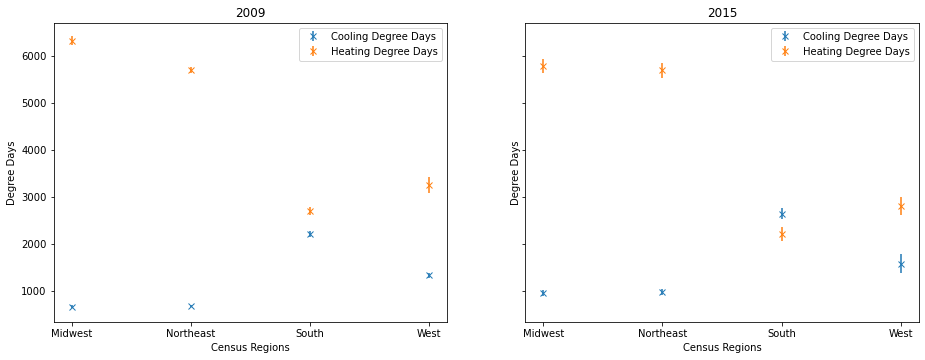

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
fig.set_size_inches(15.5, 5.5)

axes[0].set_ylabel("Degree Days")
axes[0].set_xlabel("Census Regions")
axes[0].set_title("2009")
_ = axes[0].errorbar(
    ["Midwest", "Northeast", "South", "West"],
    clean_intervals_2009["Mean CDD"],
    fmt="x",
    yerr=var_se_09["cdd_se"] * 1.96,
)

_ = axes[0].errorbar(
    ["Midwest", "Northeast", "South", "West"],
    clean_intervals_2009["Mean HDD"],
    fmt="x",
    yerr=var_se_09["hdd_se"] * 1.96,
)
_ = axes[0].legend(["Cooling Degree Days", "Heating Degree Days"])


axes[1].set_ylabel("Degree Days")
axes[1].set_xlabel("Census Regions")
axes[1].set_title("2015")
_ = axes[1].errorbar(
    ["Midwest", "Northeast", "South", "West"],
    clean_intervals_2015["Mean CDD"],
    fmt="x",
    yerr=var_se_15["cdd_se"] * 1.96,
)

_ = axes[1].errorbar(
    ["Midwest", "Northeast", "South", "West"],
    clean_intervals_2015["Mean HDD"],
    fmt="x",
    yerr=var_se_15["hdd_se"] * 1.96,
)

_ = axes[1].legend(["Cooling Degree Days", "Heating Degree Days"])

Fig1. This figure depicts the mean HDD/CDD for all the census regions,
separately for 2009 and 2015

It is observed that the South and West regions consistently have a
smaller difference between their Heating and Cooling Degree Days,
indicating they are prone to extreme temperatures on either ends.

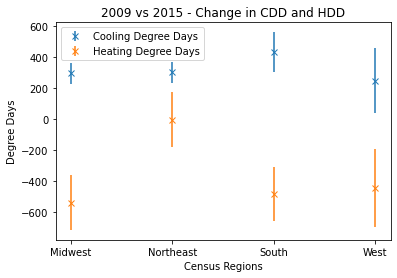

In [28]:
fig2, axes = plt.subplots(nrows=1, ncols=1)


axes.set_ylabel("Degree Days")
axes.set_xlabel("Census Regions")
axes.set_title("2009 vs 2015 - Change in CDD and HDD")
_ = axes.errorbar(
    ["Midwest", "Northeast", "South", "West"],
    clean_intervals["Change In Mean CDD"],
    fmt="x",
    yerr=se_09_15["cdd_se"] * 1.96,
)

_ = axes.errorbar(
    ["Midwest", "Northeast", "South", "West"],
    clean_intervals["Change In Mean HDD"],
    fmt="x",
    yerr=se_09_15["hdd_se"] * 1.96,
)
_ = axes.legend(["Cooling Degree Days", "Heating Degree Days"])


Fig2. This figure depicts the mean change in the Cooling/Heating
degree days, from 2009 to 2015. A negative value indicates that
the value went down from the years 2009 to 2015.